In [51]:
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# for creating animations
import matplotlib.animation
from IPython.display import HTML
# style = "<style>div.warn{background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
style = "<style>div.info{padding: 15px; border: 1px solid transparent; border-left: 5px solid #dfb5b4; border-color: transparent; margin-bottom: 10px; border-radius: 4px; background-color: #fcf8e3; border-color: #faebcc;}</style>"
HTML(style)

# The Robot

x is a column vector of position and velocity at time k.  
$$
\mathbf{\vec x_k} = 
\begin{bmatrix}
\vec p \\
\vec v
\end{bmatrix}
$$
    


For the context of this problem we will assume that all variables in the column vector x follow the gaussian distribution.

**Why do we need to make this assumption? Simplicity or ease? Truth?**

## Some background on tracking probabilities

Before we jump into the robot problem we need to recall some Bayesian principals. Recall Bayes Rule:
$$
Posterior =\frac{Likelihood \ast Prior}{Marginal}
$$
The Posterior is what we are trying to find (usually). The posteriror can be thought of a probability of an event given a certain condition (or another probability). The likelihood probability can be thought of as the probability certain condition being present given an event. Another way to think of the likelihood is the probability of observing specific data assuming the data came from a specific event. The prior can be thought of probability of an event before background knowledge is taken into account. The marginal is similar, the marginal can be thought of as the probability of data before we learn the background of the event.


I really enjoy Jayesh Thukarul's explainaiton of Bayes Rule:
https://medium.com/bright-minds-analytica/bayes-theorem-explained-66f572b875f6

The Posterior is how probable our hypothesis is given the observed evidence (Not directly calculable). The Likelihood, the prbability the evidence given that out hypothesis is true. The prior, the probability our hypothesis before observing the evidence. The marginal is the probability of new evidence under all possible hypotheses.

$$
P(H|e) = \frac{P(e|H)P(H)}{P(e)}
$$

Bayes Rule is important because the Kalman filter is essentially acting out the process of attempting to observe the posterior. Where we attempt to calculate the posterior from the likelihood time the prior. This works especially well with gaussian normal distributions because the product of 2 gaussians is another gaussian.

## Understanding different distributions using the robot's sensors

In [2]:
import seaborn as sn

In [3]:
position = np.random.normal(5,0.2**2, 1000)
movement = np.random.normal(10,0.7**2, 1000)

The distributions do not have covariance. They are independent of each other

C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


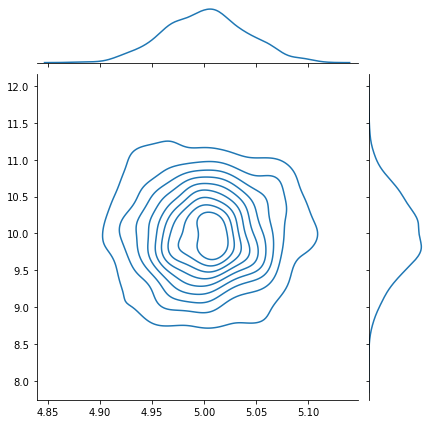

In [4]:
sn.jointplot(position, movement, kind='kde')

In [5]:
joint=np.random.multivariate_normal(mean=[5,10], cov=[[.2**2,.1],[.1,.7**2]], size=1000)

### Mess around with the variances and covariances

In [6]:
var_x = .2**2
var_y = .7**2
cov_xy = -.1

joint=np.random.multivariate_normal(mean=[5,10], cov=[[var_x,cov_xy],[cov_xy,var_y]], size=1000)

C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


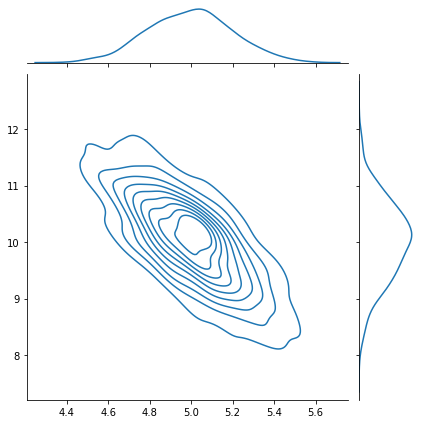

In [8]:
sn.jointplot(joint[:,0], joint[:,1], kind='kde')

lets use a different distribution for the robot's movement variable. This is for demostration purposes to exaggerate the effects of a joint distribution with marginal distriubtions being different.

In [9]:
movement = np.random.exponential(.5,1000)

C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


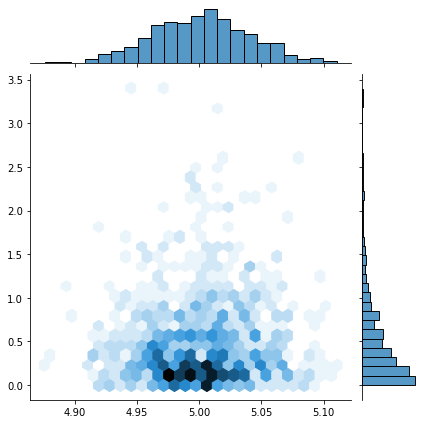

In [10]:
sn.jointplot(position, movement, kind='hex')

We can now see how to density would look for a joint probability distribution $\mathcal{f}$(position,movement). This can help us think about our conditional visualizations. Let's switch the movement variable back to a normal distribution.

In [11]:
movement = np.random.normal(10,0.7**2, 1000)

We will need a more obvious covariance between the distributions if we want the visualization to be useful. Numpy has a extremely useful function np.cov(a,b) for calculating a covariance matrix!

In [12]:
covariance = np.cov(position, movement)

In [13]:
print(covariance) # prints a nice 2 x 2 array

[[ 1.51719719e-03 -4.75018261e-06]
 [-4.75018261e-06  2.39288797e-01]]


**Let's just specify a more exaggerated covariance for the sake of visualization**

In [14]:
covariance = np.array([[20,19],
                   [19,20]])

In [15]:
mean=[np.mean(position),np.mean(movement)]
joint=np.random.multivariate_normal(mean=mean, cov=covariance, size=1000)

C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


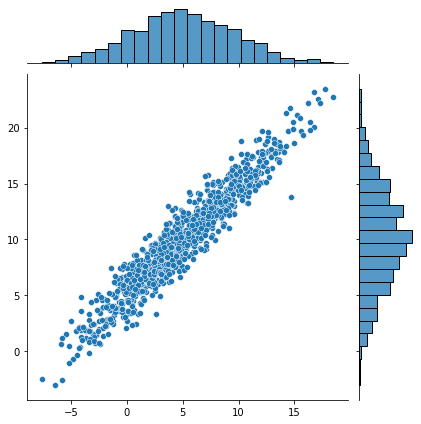

In [16]:
sn.jointplot(joint[:,0], joint[:,1])

Lets look at the conditional movement given position. $\mathcal{f}(movement|position)$. x-axis is position, movement is on the y-axis.

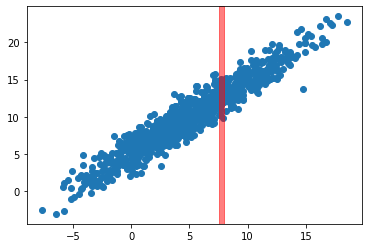

In [17]:
plt.scatter(joint[:,0],joint[:,1])
plt.axvspan(7.5, 8, color='red', alpha=0.5)
plt.show()

In [18]:
cond = np.logical_or(joint[:,0] < 7.5, joint[:,0] > 8)
cond.shape

(1000,)

In [19]:
cond = np.array(cond, dtype=bool)

In [20]:
conditional_dist = np.delete(joint, cond, axis=0)

This should give us a zoomed in plot of the red highlighted area in the plot above.

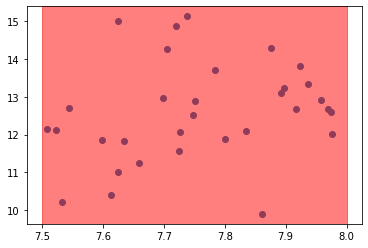

In [21]:
plt.scatter(conditional_dist[:,0],conditional_dist[:,1])
plt.axvspan(7.5, 8, color='red', alpha=0.5)
plt.show()

It infact does! Lets zoom out to our orginal axis.

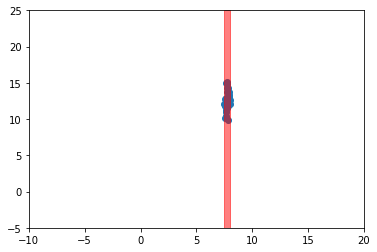

In [22]:
plt.scatter(conditional_dist[:,0],conditional_dist[:,1])
plt.axvspan(7.5, 8, color='red', alpha=0.5)
plt.ylim(-5,25)
plt.xlim(-10,20)
plt.show()

Great. So now we can see the slice of the joint distribtion. This will have to do for now, in a true probability density function everything is continuous, so technically taking a slice as we did is wrong. Let's look at a few slices at once to get a better feel for what the conditional is.

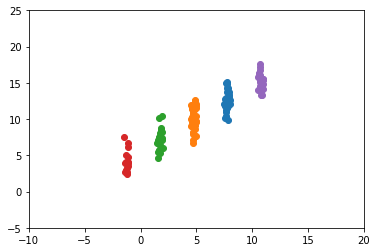

In [23]:
cond1 = np.logical_or(joint[:,0] < 7.5, joint[:,0] > 8)
cond1 = np.array(cond1, dtype=bool)

cond2 = np.logical_or(joint[:,0] < 4.5, joint[:,0] > 5)
cond2 = np.array(cond2, dtype=bool)

cond3 = np.logical_or(joint[:,0] < 1.5, joint[:,0] > 2)
cond3 = np.array(cond3, dtype=bool)

cond4 = np.logical_or(joint[:,0] < -1.5, joint[:,0] > -1)
cond4 = np.array(cond4, dtype=bool)

cond5 = np.logical_or(joint[:,0] < 10.5, joint[:,0] > 11)
cond5 = np.array(cond5, dtype=bool)

conditional_dist1 = np.delete(joint, cond1, axis=0)
conditional_dist2 = np.delete(joint, cond2, axis=0)
conditional_dist3 = np.delete(joint, cond3, axis=0)
conditional_dist4 = np.delete(joint, cond4, axis=0)
conditional_dist5 = np.delete(joint, cond5, axis=0)


plt.scatter(conditional_dist1[:,0],conditional_dist1[:,1])
plt.scatter(conditional_dist2[:,0],conditional_dist2[:,1])
plt.scatter(conditional_dist3[:,0],conditional_dist3[:,1])
plt.scatter(conditional_dist4[:,0],conditional_dist4[:,1])
plt.scatter(conditional_dist5[:,0],conditional_dist5[:,1])
plt.ylim(-5,25)
plt.xlim(-10,20)
plt.show()

Let's replicate this same process of visualization with $\mathcal{f}(position|movement)$

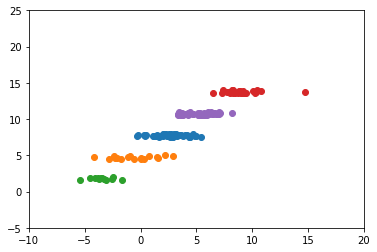

In [24]:
cond1 = np.logical_or(joint[:,1] < 7.5, joint[:,1] > 8)
cond1 = np.array(cond1, dtype=bool)

cond2 = np.logical_or(joint[:,1] < 4.5, joint[:,1] > 5)
cond2 = np.array(cond2, dtype=bool)

cond3 = np.logical_or(joint[:,1] < 1.5, joint[:,1] > 2)
cond3 = np.array(cond3, dtype=bool)

cond4 = np.logical_or(joint[:,1] < 13.5, joint[:,1] > 14)
cond4 = np.array(cond4, dtype=bool)

cond5 = np.logical_or(joint[:,1] < 10.5, joint[:,1] > 11)
cond5 = np.array(cond5, dtype=bool)

conditional_dist1 = np.delete(joint, cond1, axis=0)
conditional_dist2 = np.delete(joint, cond2, axis=0)
conditional_dist3 = np.delete(joint, cond3, axis=0)
conditional_dist4 = np.delete(joint, cond4, axis=0)
conditional_dist5 = np.delete(joint, cond5, axis=0)


plt.scatter(conditional_dist1[:,0],conditional_dist1[:,1])
plt.scatter(conditional_dist2[:,0],conditional_dist2[:,1])
plt.scatter(conditional_dist3[:,0],conditional_dist3[:,1])
plt.scatter(conditional_dist4[:,0],conditional_dist4[:,1])
plt.scatter(conditional_dist5[:,0],conditional_dist5[:,1])
plt.ylim(-5,25)
plt.xlim(-10,20)
plt.show()

## Lets breakdown it down first without vectors

$$
\bf Predict \; Stage:
\bf\bar{X} = \bf X * f_x(\bullet)
$$

$$
\bf Update \;  Stage:
\bf X = \mathcal{L} \cdot \bf\bar{X}
$$

    

This is what's called a discrete Bayes filter. It should resemble both the Kalman filter but also Bayes Theorem. If you look at the predict stage, $ \bf\bar{X} $ is the prior, $ f_x(\bullet) $ is process model (or the function/distirubtion updating the prior), while $ X $ is the input. We have $\bullet$ in the process model because the first iteration of the filter doesn't have prior information. We will likely take an educated guess. 

It's important to note that when we switch our thinking to the Kalman filter and continuous distributions that $X$ will become a vector in multivariate scenarios. As well as be representing scenarios with continuous distribtions. All $X$'s will switch to $x_\mathcal{N}$. This notation $x_\mathcal{N}$ represnets a gaussian.

## Back to the robot problem with our new understanding of Bayes Filter

#### Lets first go through the prediction process

Lets think about updating the position of the robot with the equation for velocity.

$ f_x(\bullet) $ in our case becomes $ f_x $ velocity mulitpled by the change in time. The equation for postion.

If the robot was hypothetically at 5 meters and his velocity is 10 meters, with a change in time of 1 second. He would now be at 15 meters.

The **process model** is the velocity:
$$
f_x = v_k\Delta t
$$

The **prior** in this situation can be thought of as prior robot position:
$$
\bar{x}_k = x_{k-1} + f_x
$$

Now we can include the concept of the continuous gaussian distrubtion. This is key for us because we can estimate the robot's position but we cannot know for sure, there is always a degree of uncertainty. That's why we need a variance and a standard deviation to help describe the uncertainty. Hence, the need for probability distriubtions. Here we have a standard deviation of 0.2 and 0.7.

$$
x = \mathcal{N}(5,0.2^2)
$$
$$
f_x = \mathcal{N}(10,0.7^2)
$$

Thanks to the properties of gaussians we can conviently add the previous position with the velocity. Hence the new position being at 15 meters.

$$
\bar{x} = \mu_x + \mu_{f_x} = 5 + 10 = 15
$$
$$
\bar{\sigma}^2 = \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 = 0.53
$$

We can use function, for now, to predict:



 As you can see we using the current position + the movement, with the summation being the uncertainty
 Another thing to remember, the position and movement are gaussians that need to be defined

In [25]:
def predict(position, movement):
    return np.random.normal(np.mean(position) + np.mean(movement), np.var(position) + np.var(movement), 100)

In [26]:
position = np.random.normal(5,0.2**.5, 1000)
movement = np.random.normal(10,0.7**2, 1000)

You can think of the following graph as 1000 sensor readings when the robot was at position 5.

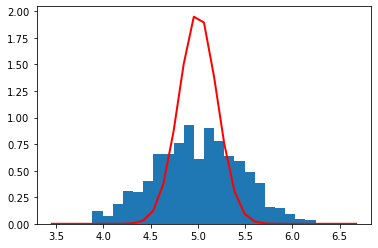

In [27]:
count, bins, ignored = plt.hist(position, 30, density=True) # density = True turns the plot into a representation in the probability distribution, very useful, we will return to it in the future.
plt.plot(bins, 1/(.2 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - 5)**2 / (2 * .2**2) ),
         linewidth=2, color='r')
plt.show()

Likewise, this graph can be thought of as 1000 sensor readings for the robot velocity

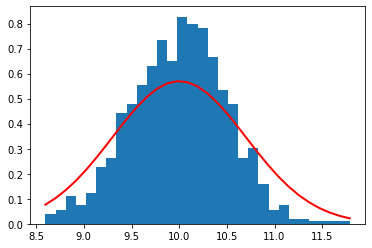

In [28]:
count, bins, ignored = plt.hist(movement, 30, density=True)
plt.plot(bins, 1/(0.7 * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - 10)**2 / (2 * 0.7**2) ),
         linewidth=2, color='r')
plt.show()

Let's now see the prediction!

In [29]:
new_position = predict(position, movement)

In [30]:
mu = np.mean(new_position)
sigma = np.std(new_position) # or np.var()**.5

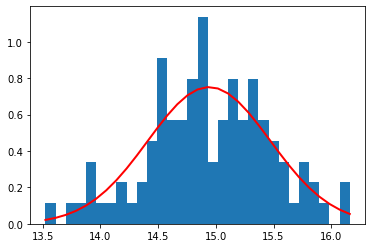

In [31]:
count, bins, ignored = plt.hist(new_position, 30, density=True) 
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

Great! We have a prediciton to what our new sensor readings should be for our robot position!

### Now we can update, a key piece of the filter process, lets take a look at new sensor informaiton

As preivously mentioned we now use the update equation:
$$
\bf Update \;  Stage:
\bf X = \mathcal{L} \cdot \bf\bar{X}
$$
    


Our sensor now states that the robot is at 17 meters with a uncertainty(standard deviation) of 0.4.

This can be thought of as our likelihood. It can be slightly confusing when converting the thinking between theortical probablites probability distributions. But...bear with us. The previous outcome from the prediciton stage was a prediction! This is actual sensor readings coming in to where the robot landed.

$$
\mathcal{L} = \mathcal{N}(17,0.4^2)
$$
We are going to switch the likelihood notation to $\mathcal{z}$ 

Remember $\bf\bar{X}$ is the prior, lets do some Gaussian multiplication!

as you can see the mu's and sigma's have a subscript representative of which Gaussian they belong to, the bar belongs to the prior, hence, $\bf\bar{X}$.

Property of Gaussian multiplication:

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

Our Gaussian multiplication:
$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

In [38]:
def gaussian_multiply(g1, g2):
    
    mean = ((np.var(g1) * np.mean(g2)) + (np.var(g2) * np.mean(g1))) / (np.var(g1) + np.var(g2))
    variance = ((np.var(g1)*np.var(g2))/(np.var(g1)+np.var(g2)))
    return np.random.normal(mean, variance, 100)

def update(prior, likelihood):
    posterior = gaussian_multiply(prior, likelihood)
    return posterior

In [39]:
like = np.random.normal(17,0.4**2, 1000)
posterior = update(new_position, like)

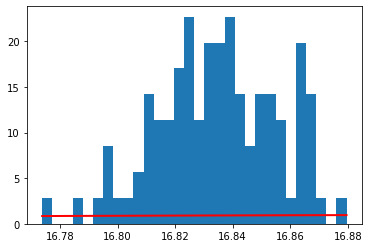

In [43]:
count, bins, ignored = plt.hist(posterior, 30, density=True) 
plt.plot(bins, 1/(0.4 * np.sqrt(2 * np.pi)) *np.exp( - (bins - 17)**2 / (2 * 0.4**2)),linewidth=2, color='r')
plt.show()

# Simulating robot position and velocity

In [34]:
# time - 10 seconds
time_duration = 100
# starting position 5 units

# movement velocity of 10 units

def robot_simulation(starting_pos, starting_vel, position_var,velocity_var, time_duration):
    robot_record=[starting_pos]
    for i in range(1,time_duration):
        new_pos = robot_record[(i-1)] + starting_vel + np.random.randint(-20,5,1) + i
        robot_record.append(int(new_pos))
    return np.array(robot_record)

starting_pos = 5
starting_vel = 10
position_var = 20
velocity_var = 10

robot_record = robot_simulation(starting_pos=starting_pos,
                                velocity_var=velocity_var,
                                position_var=position_var,
                                starting_vel=starting_vel,
                                time_duration=time_duration)

robot_record.shape

(100,)

In [35]:
def gaussian_multiply(g1, g2):
    
    mean = ((np.var(g1) * np.mean(g2)) + (np.var(g2) * np.mean(g1))) / (np.var(g1) + np.var(g2))
    variance = ((np.var(g1)*np.var(g2))/(np.var(g1)+np.var(g2)))
    return np.random.normal(mean, variance, 100)


def update(prior, likelihood):
    posterior = gaussian_multiply(prior, likelihood)
    return posterior

def predict(position, movement):
    return np.random.normal(np.mean(position) + np.mean(movement), np.var(position) + np.var(movement), 100) #MAP mean of post

In [36]:
post = []
priors = []
pos = np.random.normal(5,1, 100)
vel = np.random.normal(10,1, 100)
for i,z in enumerate(robot_record):
    prior = predict(pos, vel)
    print('prior: ',np.mean(prior))
    likelihood = np.random.normal(z,size=100) 
    print('likelihood: ',np.mean(likelihood))
    pos = update(prior, likelihood)
    print('pos: ', np.mean(pos))
    priors.append(prior)
    post.append(pos)
    print("")

prior:  15.039995902435315
likelihood:  5.171843070659268
pos:  6.546159158261229

prior:  16.76404122366939
likelihood:  -1.1116357844749603
pos:  3.043987456030685

prior:  13.243040840725353
likelihood:  14.944286528840452
pos:  14.4758159154238

prior:  24.217202973106037
likelihood:  29.039465050938876
pos:  27.87037477620369

prior:  37.69618881277952
likelihood:  31.155627710979157
pos:  32.96513432763602

prior:  42.88267206533758
likelihood:  35.99180708353287
pos:  38.313958480358004

prior:  48.13568251399787
likelihood:  55.90843681172207
pos:  54.15780684779115

prior:  64.08247665443031
likelihood:  57.075442506624285
pos:  58.34373949362852

prior:  68.30497707950427
likelihood:  69.0051415752549
pos:  68.7386557867123

prior:  78.63766518286039
likelihood:  88.07693817562863
pos:  85.36264441725142

prior:  95.0807072459954
likelihood:  91.104354666813
pos:  92.21301972259947

prior:  102.2417185519906
likelihood:  110.98948842849903
pos:  107.89675043539442

prior:  11

(array([0.02640501, 0.10562005, 0.13202506, 0.31686015, 0.34326516,
        0.6337203 , 0.47529022, 0.26405012, 0.18483509, 0.15843007]),
 array([4.42017769, 4.79889366, 5.17760964, 5.55632561, 5.93504158,
        6.31375756, 6.69247353, 7.0711895 , 7.44990548, 7.82862145,
        8.20733742]),
 <BarContainer object of 10 artists>)

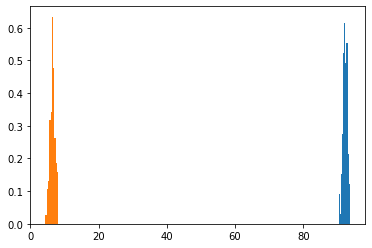

In [255]:
plt.hist(post[10], density=True)
plt.hist(post[0], density=True)

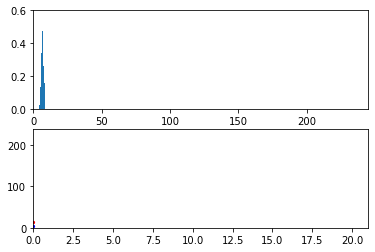

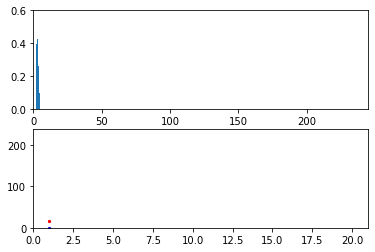

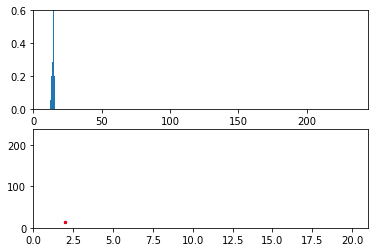

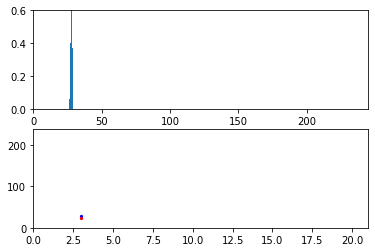

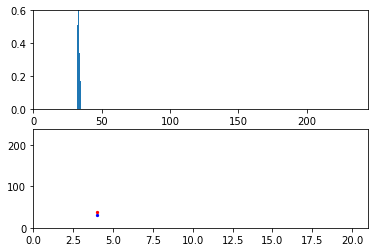

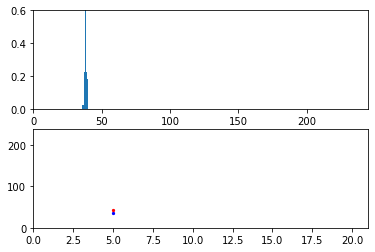

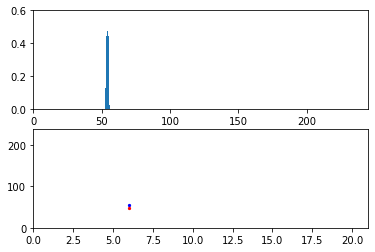

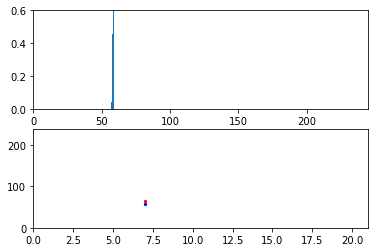

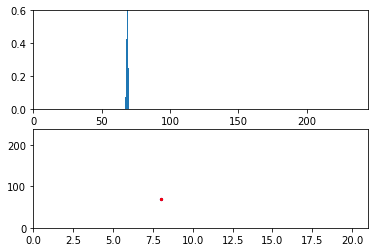

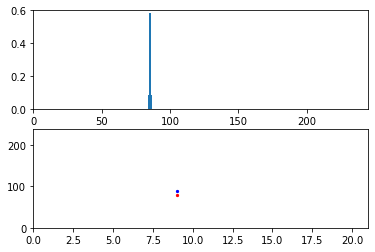

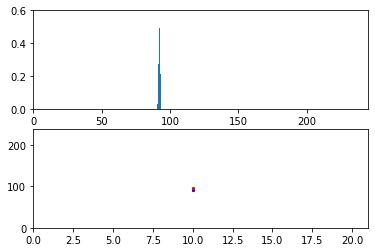

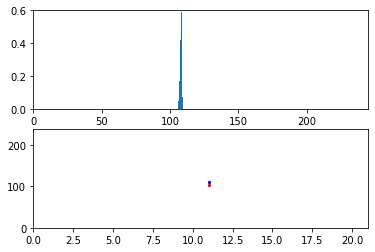

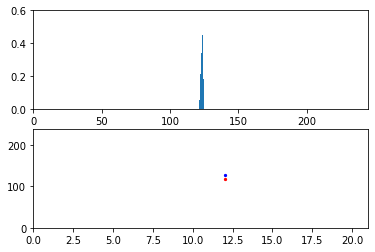

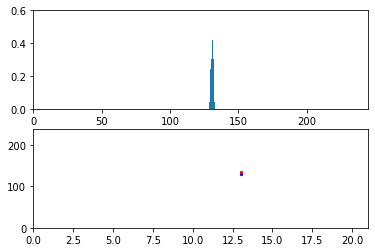

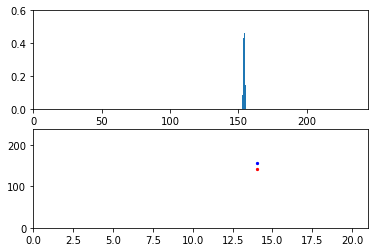

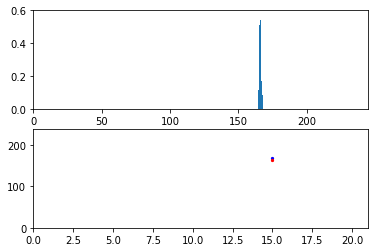

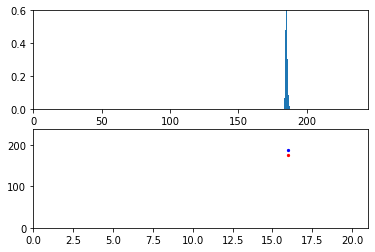

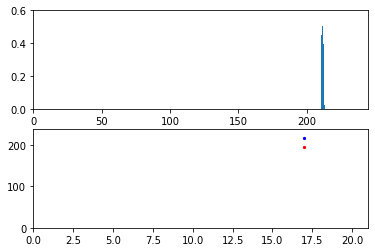

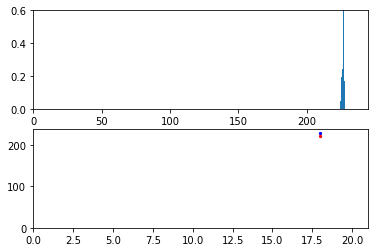

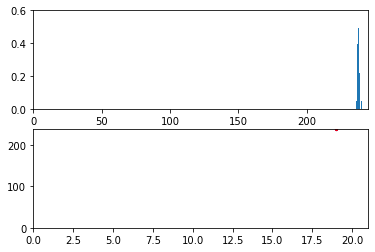

In [264]:
for i in range(20):
    fig, axs = plt.subplots(2)
    axs[0].set_xlim([0,245])
    axs[0].set_ylim([0,.6])
    axs[1].set_ylim([0,238])
    axs[1].set_xlim([0,21])
    axs[0].hist(post[i], density = True)
    axs[1].scatter(time_array[i],robot_record[i], c='blue', s=5)
    axs[1].scatter(time_array[i], np.mean(priors, axis=1)[i], c='red', s=5)
    plt.savefig(str(i)+'.png')
    plt.show
    #for every frame hard code max for x and y axis 
    

In [265]:
import imageio

with imageio.get_writer('hist.gif', mode='I') as writer:
    for filename in ['0.png','1.png', '2.png', '3.png', '4.png','5.png','6.png','7.png','8.png','9.png','10.png','11.png', '12.png', '13.png', '14.png','15.png','16.png','17.png','18.png','19.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

In [268]:
gif = imageio.mimread('hist.gif')
imageio.mimsave('hist.gif', gif, fps=.9)

<img src="hist.gif" width="750" align="center">

In [37]:
np.mean(priors, axis=1)

array([  15.0399959 ,   16.76404122,   13.24304084,   24.21720297,
         37.69618881,   42.88267207,   48.13568251,   64.08247665,
         68.30497708,   78.63766518,   95.08070725,  102.24171855,
        118.24649467,  133.61005057,  140.83887259,  164.36382336,
        176.06858848,  195.13869103,  221.39492465,  236.74843948,
        247.71417248,  271.25636285,  299.98560769,  314.8715398 ,
        328.72927206,  348.06375308,  369.26330042,  398.9785552 ,
        424.1038254 ,  447.99664938,  471.24860198,  503.24080979,
        538.60939858,  575.0099909 ,  614.11929614,  653.02390198,
        695.54863017,  741.01603381,  785.45560047,  834.09810651,
        869.50155204,  904.32385377,  941.37314521,  974.98314291,
       1021.25096888, 1071.65492869, 1109.64093933, 1162.75444183,
       1215.76701209, 1264.63209548, 1327.4527774 , 1380.06364466,
       1436.18438992, 1485.35527599, 1541.13524071, 1588.26348608,
       1640.26188875, 1703.00691903, 1757.81977698, 1810.80562

In [534]:
for i in range(len(priors)):
    print("Iteration: ",i)
    print("Robot Measurment/Record",robot_record[i])
    print("Prior",np.mean(priors[i]))
    print("")

Iteration:  0
Robot Measurment/Record 5
Prior 15.039995902435315

Iteration:  1
Robot Measurment/Record -1
Prior 16.76404122366939

Iteration:  2
Robot Measurment/Record 15
Prior 13.243040840725353

Iteration:  3
Robot Measurment/Record 29
Prior 24.217202973106037

Iteration:  4
Robot Measurment/Record 31
Prior 37.69618881277952

Iteration:  5
Robot Measurment/Record 36
Prior 42.88267206533758

Iteration:  6
Robot Measurment/Record 56
Prior 48.13568251399787

Iteration:  7
Robot Measurment/Record 57
Prior 64.08247665443031

Iteration:  8
Robot Measurment/Record 69
Prior 68.30497707950427

Iteration:  9
Robot Measurment/Record 88
Prior 78.63766518286039

Iteration:  10
Robot Measurment/Record 91
Prior 95.0807072459954

Iteration:  11
Robot Measurment/Record 111
Prior 102.2417185519906

Iteration:  12
Robot Measurment/Record 126
Prior 118.24649467292258

Iteration:  13
Robot Measurment/Record 130
Prior 133.61005057380936

Iteration:  14
Robot Measurment/Record 157
Prior 140.8388725878948

In [39]:
time_array = np.array(list(range(time_duration)))

Text(0, 0.5, 'p ~ position')

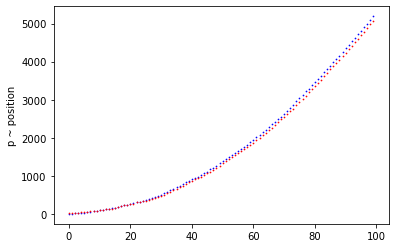

In [40]:
plt.scatter(time_array,robot_record, c='blue', s=.5)
plt.scatter(time_array, np.mean(priors, axis=1), c='red', s=.5)
plt.ylabel('p ~ position')

(0.0, 200.0)

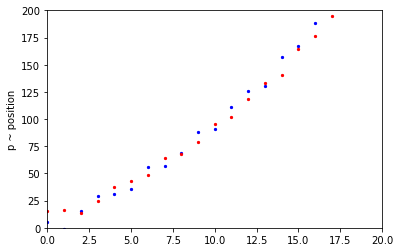

In [41]:
plt.scatter(time_array,robot_record, c='blue',s=5)
plt.scatter(time_array, np.mean(priors, axis=1), c='red',s=5)
plt.ylabel('p ~ position')
plt.xlim(0,20)
plt.ylim(0,200)

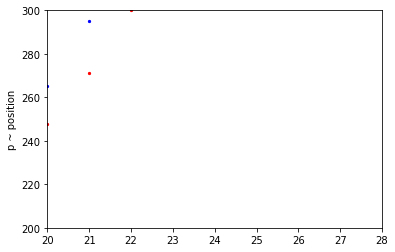

In [42]:
plt.scatter(time_array,robot_record, c='blue', s=5)
plt.scatter(time_array, np.mean(priors, axis=1), c='red', s=5)
plt.ylabel('p ~ position')
plt.ylim(200,300)
plt.xlim(20,28);

GIF moving Gaussian dist.

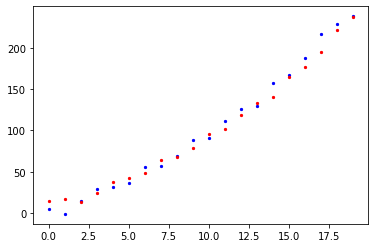

In [43]:
for i in range(20):
    plt.scatter(time_array[i],robot_record[i], c='blue', s=5)
    plt.scatter(time_array[i], np.mean(priors, axis=1)[i], c='red', s=5)
    plt.savefig(str(i)+'.png')
    plt.show
    #for every frame hard code max for x and y axis 
    

In [44]:
import imageio

with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in ['0.png','1.png', '2.png', '3.png', '4.png','5.png','6.png','7.png','8.png','9.png','10.png','11.png', '12.png', '13.png', '14.png','15.png','16.png','17.png','18.png','19.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src="mygif.gif" width="750" align="center">

In [45]:
gif = imageio.mimread('mygif.gif')
imageio.mimsave('mygif2.gif', gif, fps=.5)

<img src="mygif2.gif" width="750" align="center">

In [46]:
gif = imageio.mimread('mygif.gif')
imageio.mimsave('mygif3.gif', gif, fps=1)

<img src="mygif3.gif" width="750" align="center">

Text(0, 0.5, 'p ~ position')

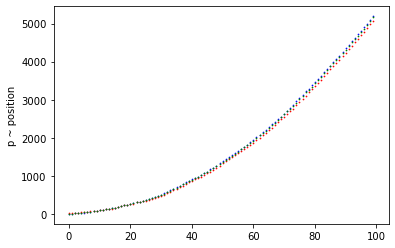

In [47]:
plt.scatter(time_array,robot_record, c='blue', s=.5)
plt.scatter(time_array, np.mean(priors, axis=1), c='red', s=.5)
plt.scatter(time_array, np.mean(post, axis=1), c='green', s=.5)
plt.ylabel('p ~ position')

(0.0, 200.0)

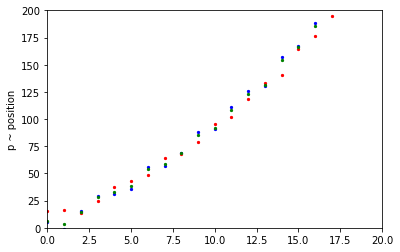

In [48]:
plt.scatter(time_array,robot_record, c='blue',s=5)
plt.scatter(time_array, np.mean(priors, axis=1), c='red',s=5)
plt.scatter(time_array, np.mean(post, axis=1), c='green', s=5)
plt.ylabel('p ~ position')
plt.xlim(0,20)
plt.ylim(0,200)

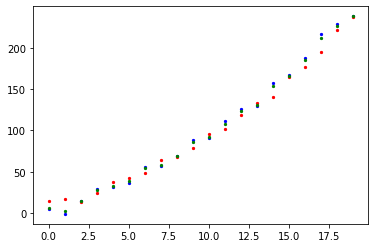

In [49]:
for i in range(20):
    plt.scatter(time_array[i],robot_record[i], c='blue', s=5)
    plt.scatter(time_array[i], np.mean(priors, axis=1)[i], c='red', s=5)
    plt.scatter(time_array[i], np.mean(post, axis=1)[i], c='green', s=5)
    plt.savefig(str(i)+'withpost.png')
    plt.show
    

In [50]:

with imageio.get_writer('mygifwithpost.gif', mode='I') as writer:
    for filename in ['0withpost.png','1withpost.png', '2withpost.png', '3withpost.png', '4withpost.png','5withpost.png','6withpost.png','7withpost.png','8withpost.png','9withpost.png','10withpost.png','11withpost.png', '12withpost.png', '13withpost.png', '14withpost.png','15withpost.png','16withpost.png','17withpost.png','18withpost.png','19withpost.png']:
        image = imageio.imread(filename)
        writer.append_data(image)


In [51]:
gif = imageio.mimread('mygifwithpost.gif')
imageio.mimsave('mygifwithpost.gif', gif, fps=1)

<img src="mygifwithpost.gif" width="750" align="center">

# Univariate Bayesian Filter to Multivariate Kalman Form

### Predict
Univariate Bayesian:
$$
\bf\bar{X} = \bf X * f_x(\bullet)
$$
    
$$
\bar{x} = \mu_x + \mu_{f_x}
$$
$$
\bar{\sigma}^2 = \sigma_x^2 + \sigma_{f_x}^2
$$

Univariate Kalman:
$$
\bar{x} = x + dx
$$
$$
\bar{P} = P + Q
$$

Multivariate Kalman:
$$
\bar{\textbf{x}} = \textbf{Fx} + \textbf{Bu}
$$
$$
\bar{\textbf{P}} = \textbf{FPF}^{\textbf{T}} + \textbf{Q}
$$


$\textbf{x}$,$\textbf{P}$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.

$\textbf{F}$ is the state transition function. When multiplied by $\textbf{x}$ it computes the prior.

$\textbf{Q}$ is the process noise covariance (additional unaccounted for parameters). It corresponds to $\sigma^2_{f_x}$. It also keeps state covariance matrix from becoming too small or going to 0.

$\textbf{B}$ and $\textbf{u}$ are new to us. They let us model control inputs to the system.

### Update
Univariate Bayesian:
$$
\bf X = \mathcal{L} \cdot \bf\bar{X}
$$

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

Multivariate Kalman:
$$
\bf{y} = \bf{z} - \bf{H\bar{x}}
$$
$$
\bf{K} = \bf{\bar{P}H^T} (\bf{H\bar{P}H^T} + \bf{R})^{-1}
$$
$$
\bf{x} = \bf{\bar{x}} + \bf{Ky}
$$
$$
\bf{P} = (\bf{I} - \bf{KH})\bf{\bar{P}}
$$


The details will be different than the univariate filter because these are vectors and matrices, but the concepts are exactly the same:

$\bullet$ Use a Gaussian to represent our estimate of the state and error

$\bullet$ Use a Gaussian to represent the measurement and its error

$\bullet$ Use a Gaussian to represent the process model

$\bullet$ Use the process model to predict the next state (the prior)

$\bullet$ Form an estimate part way between the measurement and the prior

In [52]:
import math
import numpy as np
from numpy.random import randn

# assumed sensor variance = sensor_var
# velocity varies due to process variance = process_var
# length of the simulation = time_duration

sensor_var = 1.5
process_var = 4
time_duration = 10

def compute_robot_data(sensor_var, process_var, time_duration=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 4.5
    sensor_std = math.sqrt(sensor_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(time_duration):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * sensor_std)        
    return np.array(xs), np.array(zs)

xs, zs = compute_robot_data(sensor_var=sensor_var, process_var=process_var, time_duration=time_duration)


In [53]:
xs

array([ 5.38493456, 11.33143949, 13.88266104, 18.58233193, 21.1983529 ,
       23.32575028, 28.06278791, 32.21719878, 37.42878054, 40.54992043])

In [54]:
zs

array([ 4.59296472,  9.61741854, 14.34586832, 19.40796919, 18.83162798,
       23.99327648, 28.19312575, 32.91334893, 37.04342537, 42.76029248])

Returning to vector notation:
$$
\mathbf{\vec x_k} = 
\begin{bmatrix}
\vec p \\
\vec v
\end{bmatrix}
$$
    
Our vector is storing state variables, such as position and velocity, what makes a Kalman filter a Kalman filter is the implementation of linear algerbra


In [55]:
x = np.array([[10.0],
              [4.5]])
x

array([[10. ],
       [ 4.5]])

In [56]:
x = np.array([[10., 4.5]]).T
x

array([[10. ],
       [ 4.5]])

In [57]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

In [58]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.0], [4.5]])

# matrix multiply
print(np.dot(A, x))
print()

[[19.]
 [48.]]



In [59]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

In [60]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

Linear algerbra solving system of equations

In [61]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

$\textbf{F}$ is called the state transition function or the state transition matrix. In later chapters it will be a true function, not a matrix, so calling it a function is a bit more general. Our job as Kalman filters designers is to specify $\textbf{F}$ such that $\bar{x} = Fx$ performs the innovation (prediction) for our system. To do this we need one equation for each state variable. In our problem $x = [x \space{  }  x˙]^T$, so we need one equation to compute the position x and another to compute the velocity x˙ . We already know the equation for the position innovation:


In [62]:
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

In [63]:
x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

In [64]:
print('state variables: ',x)
print()
print('Covariance Matrix: ')
print(P)
print()
print('State Transition Matrix')
print(F)

state variables:  [10.   4.5]

Covariance Matrix: 
[[500   0]
 [  0  49]]

State Transition Matrix
[[1.  0.1]
 [0.  1. ]]


In [66]:
def predict(x=None, P=None, u=None, B=None, F=None, Q=None):
    if (B is None) & (u is None):
        # x = Fx + Bu
        x_bar = np.dot(F,x)
    else:
        x_bar = np.dot(F,x) + np.dot(B,u)
    
    if (Q is None):
        # P = FPF^T + Q
        P_bar = np.dot(np.dot(F, P), F.T)
    else:
        P_bar = np.dot(np.dot(F,P), F.T) + Q
        
    x_prior = x_bar
    P_prior = P_bar
    # save prior
    return x_prior, P_prior


In [67]:
x_prior, P_prior = predict(x=x,P=P,F=F)

In [68]:
x_prior

array([10.45,  4.5 ])

In [69]:
P_prior

array([[500.49,   4.9 ],
       [  4.9 ,  49.  ]])

In [70]:
predict(x=x,P=P,F=F)

(array([10.45,  4.5 ]),
 array([[500.49,   4.9 ],
        [  4.9 ,  49.  ]]))

To model real life scenarios better we need $\bf{Q}$ to be some kind of white noise that would arise in real life scenarios.

In [71]:
# Our dim would be 2, position and velocity
# Our dt would be 1, time step, if dt = 1 the variance of the variables woul... lot of time lot of noise, one time~relative noise
# Our variance would be how much noise we want
# Need if your state variable contains more than on dimension, provides us we a block diagonal matrix
from scipy.linalg import expm, block_diag

def Q_white_noise(dim,dt,var, block_size):
    if not (dim == 2 or dim == 3 or dim == 4):
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]
    return block_diag(*[Q]*block_size) * var


In [72]:
Q_white_noise(2,1,2.5,1)

array([[0.625, 1.25 ],
       [1.25 , 2.5  ]])

As stated before $\textbf{B}$ and $\textbf{u}$ are new to us. They let us model control inputs to the system. In the robot example they let us say speed up or slow down, if they were 0, we would have no input into the model.

In [92]:
B = 0
u = 0
dt=1
x = np.array([[10.0], [4.5], [10], [4.5]])
P = np.diag([500, 49, 500, 49])
Q = Q_white_noise(np.shape(P)[0],1,2.5,1)
F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0,0,1,0],[0,0,dt,1]])

In [93]:
x, P = predict(x=x, P=P, F=F, Q=Q, B=B, u=u)
print('x:')
print(x)
print('P:')
print(P)

x:
[[14.5]
 [ 4.5]
 [10. ]
 [14.5]]
P:
[[5.49069444e+02 4.92083333e+01 4.16666667e-01 4.16666667e-01]
 [4.92083333e+01 4.96250000e+01 1.25000000e+00 1.25000000e+00]
 [4.16666667e-01 1.25000000e+00 5.02500000e+02 5.02500000e+02]
 [4.16666667e-01 1.25000000e+00 5.02500000e+02 5.51500000e+02]]


Prediction: Summary
Your job as a designer is to specify the matrices for

$\bullet$  $\bf{x}$, $\bf{P}$: the state and covariance, (P = Error in estimate)

$\bullet$ $\bf{F}$, $\bf{Q}$: the process model and noise covariance

$\bullet$ $\bf{B}$, $\bf{u}$: Optionally, the control input and function

It's important to keep in mind, we are the designers of the filter. For me, the mind set of plugging and chugging variable values needs to change when designing the filter.

### Update Phase

$$
\bf{y} = \bf{z} - \bf{H\bar{x}}
$$
$$
\bf{K} = \bf{\bar{P}H^T} (\bf{H\bar{P}H^T} + \bf{R})^{-1}
$$
$$
\bf{x} = \bf{\bar{x}} + \bf{Ky}
$$
$$
\bf{P} = (\bf{I} - \bf{KH})\bf{\bar{P}}
$$


**Important things to note:**

$\bf{R}$ is the measurement covariacne matrix which is the error in measurement. When $\bf{R}$ goes to 0 then the Kalman gain goes closer to 1. This is adjusting primarly with the measurement update. If $\bf{R}$ is large then $\bf{K}$ goes to 0. This is adjusting primarly with the prior/predicted state. 

As $\bf{P}$ approaches 0 then measurement updates are mostly ignored.

In [94]:
"""
R is a covariance matrix for noise measurement. The matrix is m x m. Where m is the number of sensors.
H is a measurment function. 
So we take the prior and covert it to a measurement by multiplying with H, and subtract that from the measurement. 
This gives us the difference between our prediction and measurement in measurement space!
z is the measurement of the robot or whatever we're measuring.
dim_x : int
    Number of state variables for the Kalman filter. For example, if
    you are tracking the position and velocity of an object in two
    dimensions, dim_x would be 4.
    This is used to set the default size of P, Q, and u

dim_z : int
    Number of measurement inputs. For example, if the sensor
    provides you with position in (x,y), dim_z would be 2.
"""

def update(x, P, z, R=None, H=None):
    dim_x = np.shape(x)[0] # Number of state variables
    dim_z = np.shape(z)[0] # Number of measurement inputs.
    
    print("dim_x:", dim_x)
    print("dim_z:", dim_z)
    
    print("")
    print("x:")
    print(x)
    
    # y = z - Hx
    if H is None:
        H = np.ones((dim_z, dim_x)) # in the documentation it's zeros, but ones works for me
        print("H:")
        print(H)
        #H = H.reshape(np.shape(H)[0],1)
        print("H:")
        print(H)
        
        
    print("H:")
    print(H)
    print("")
    print("Error (residual calculation):")
    print("")
    print("z:")
    print(z)
    print("")
    print("H(x_bar):")
    print(np.dot(H,x))
    print("")
    
    # error (residual) between measurement and prediction
    y = z - np.dot(H, x)
    
    
    print('y or error:')
    print("y = z - np.dot(H, x)")
    print(y)
    print("")
    print("")
    print("Kalman Filter Calculation:")
    print("P:")
    print(P)
    print("H.T:")
    print(H.T)
    print("")
    print("PHT:")
    
    
    PHT = np.dot(P, H.T)
    print(PHT)
    #PHT = PHT.reshape(np.shape(PHT)[-1],1)
    print(np.shape(PHT))
    
    if R is None:
        R = np.eye(np.shape(H)[0])
        
    print("")
    print("R:")
    print(R)
    print("")
    print("System Uncertainty in measurement space:")
    # project system uncertainty into measurement space
    print("")
    
    # S = HPH' + R
    #S = np.dot(H, PHT) + R
    S = np.dot(np.dot(H, P), H.T) + R

    
    print("System Uncertainty / S:")
    print("np.dot(H, PHT) + R")
    print(S)
    print("")
    print("S inverse:")
    
    
    SI = np.linalg.inv(S)
    
    
    print(SI)
    print("")
    print("Kalman measurment / K:")
    
    
    # K = PH'inv(S)
    # map system uncertainty into kalman gain
    
    
    print("K = np.dot(PHT, SI)")
    
    
    K = np.dot(PHT, SI) # K is wrong, K I believe should be a scalar
    
    
    print(K)
    print("")
    print("Develop Posterior")
    print("x = x + Ky")
    print("")
    
    
    #y = y.reshape(1,np.shape(y)[1])
    
        
    
    print("")
    print("x_old:")
    print(x)
    print("")
    
    
    # x = x + Ky
    # predict new x with residual scaled by the kalman gain
    #x = x + np.dot(K, y)
    x = x + np.dot(K,y)
    
    print("x_new:")
    print("      x_new = x_old + np.dot(K, y)")
    print("np.dot(K, y)")
    print(np.dot(K, y))
    print("")
    print("x_new  /  Post")
    print(x)
    print("")

    # P = (I-KH)P(I-KH)' + KRK'
    # This is more numerically stable
    # and works for non-optimal K vs the equation
    # P = (I-KH)P usually seen in the literature.
    print("I_KH = np.eye(dim_x) - np.dot(K, H)")
    print("")
    print("np.eye(dim_x):")
    print(np.eye(dim_x))
    print("")
    print("np.dot(K, H)")
    print(np.dot(K, H))
    print("")
    
    
    I_KH = np.eye(dim_x) - np.dot(K, H)
    
    
    print("I_KH:")
    print(I_KH)
    
    
    P = np.dot(np.dot(I_KH, P), I_KH.T) + np.dot(np.dot(K, R), K.T)
    
    
    P_post = P
    x_post = x
    return x_post, P_post

In [95]:
z = np.array([[15],
             [15]])
H =np.array([[1,0, 0, 0],
            [0,0,1,0]])
x, P = update(x=x, P=P, z=z, R=None, H=H)
print('Post:')
print(x)
print("")
print("P Post:")
print(P)

dim_x: 4
dim_z: 2

x:
[[14.5]
 [ 4.5]
 [10. ]
 [14.5]]
H:
[[1 0 0 0]
 [0 0 1 0]]

Error (residual calculation):

z:
[[15]
 [15]]

H(x_bar):
[[14.5]
 [10. ]]

y or error:
y = z - np.dot(H, x)
[[0.5]
 [5. ]]


Kalman Filter Calculation:
P:
[[5.49069444e+02 4.92083333e+01 4.16666667e-01 4.16666667e-01]
 [4.92083333e+01 4.96250000e+01 1.25000000e+00 1.25000000e+00]
 [4.16666667e-01 1.25000000e+00 5.02500000e+02 5.02500000e+02]
 [4.16666667e-01 1.25000000e+00 5.02500000e+02 5.51500000e+02]]
H.T:
[[1 0]
 [0 0]
 [0 1]
 [0 0]]

PHT:
[[5.49069444e+02 4.16666667e-01]
 [4.92083333e+01 1.25000000e+00]
 [4.16666667e-01 5.02500000e+02]
 [4.16666667e-01 5.02500000e+02]]
(4, 2)

R:
[[1. 0.]
 [0. 1.]]

System Uncertainty in measurement space:

System Uncertainty / S:
np.dot(H, PHT) + R
[[5.50069444e+02 4.16666667e-01]
 [4.16666667e-01 5.03500000e+02]]

S inverse:
[[ 1.81795342e-03 -1.50443017e-06]
 [-1.50443017e-06  1.98609856e-03]]

Kalman measurment / K:
K = np.dot(PHT, SI)
[[9.98182047e-01 1.5044301

In [468]:
def update(x, P, z, R=None, H=None):
    z = np.asarray([z])
    dim_x = np.shape(x)[0] # Number of state variables
    dim_z = np.shape(z)[0] # Number of measurement inputs.
    # y = z - Hx
    if H is None:
        H = np.ones((dim_z, dim_x)) # in the documentation it's zeros, but ones works for me
    # error (residual) between measurement and prediction
    y = z - np.dot(H, x)
    PHT = np.dot(P, H.T)
    if R is None:
        R = np.eye(dim_z)
    # project system uncertainty into measurement space
    # S = HPH' + R
    #S = np.dot(H, PHT) + R
    S = np.dot(np.dot(H, P), H.T) + R
    SI = np.linalg.inv(S)
    # K = PH'inv(S)
    # map system uncertainty into kalman gain
    K = np.dot(PHT, SI) # K is wrong, K I believe should be a scalar
    # x = x + Ky
    # predict new x with residual scaled by the kalman gain
    #x = x + np.dot(K, y)
    x = x + np.dot(K,y)
    # P = (I-KH)P(I-KH)' + KRK'
    # This is more numerically stable
    # and works for non-optimal K vs the equation
    # P = (I-KH)P usually seen in the literature.
    I_KH = np.eye(dim_x) - np.dot(K, H)
    P = np.dot(np.dot(I_KH, P), I_KH.T) + np.dot(np.dot(K, R), K.T)
    P_post = P
    x_post = x
    return x_post, P_post

In [452]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
#Q = Q_white_noise(dim=2, dt=dt, var=Q_var, 1)
Q = Q_white_noise(dim=2,dt=dt,var=Q_var,block_size=1)

In [517]:
B = 0
u = 0
dt=1
x = np.array([[10.0], [4.5]])
P = np.diag([500, 49])
Q = Q_white_noise(np.shape(P)[0],1,2.5,1)
F = np.array([[1, dt], [0, 1]])
H = np.array([[1,0]])


In [518]:
import math
import numpy as np
from numpy.random import randn

# assumed sensor variance = sensor_var
# velocity varies due to process variance = process_var
# length of the simulation = time_duration

sensor_var = 1.5
process_var = 4
time_duration = 20

def compute_robot_data(sensor_var, process_var, time_duration=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 4.5
    sensor_std = math.sqrt(sensor_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(time_duration):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * sensor_std)        
    return np.array(xs), np.array(zs)

track, zs = compute_robot_data(sensor_var=sensor_var, process_var=process_var, time_duration=time_duration)
covs = []
xs = []
for z in zs:
    x, P = predict(x=x, P=P, F=F, Q=Q, B=B, u=u)
    x, P = update(x=x, P=P, z=z, R=None, H=H)
    xs.append(x)
    covs.append(P)


In [505]:
xs = np.array(xs)

In [506]:
np.shape(xs)

(20, 2, 1)

In [519]:
xs = np.squeeze(xs, axis=2)

In [520]:
np.shape(xs)

(20, 2)

In [521]:
np.shape(covs)

(20, 2, 2)

In [522]:
covs

[array([[ 0.99818388,  0.09125993],
        [ 0.09125993, 46.91418842]]),
 array([[0.97988733, 0.97054612],
        [0.97054612, 2.58005033]]),
 array([[0.85966941, 0.67367055],
        [0.67367055, 1.8460299 ]]),
 array([[0.8238829 , 0.6639087 ],
        [0.6639087 , 1.84329296]]),
 array([[0.82206384, 0.66854202],
        [0.66854202, 1.83144576]]),
 array([[0.82192444, 0.66778119],
        [0.66778119, 1.82727447]]),
 array([[0.8217393 , 0.66759626],
        [0.66759626, 1.82708932]]),
 array([[0.82171577, 0.66761838],
        [0.66761838, 1.82706841]]),
 array([[0.82171577, 0.66761861],
        [0.66761861, 1.82704581]]),
 array([[0.82171506, 0.66761726],
        [0.66761726, 1.8270432 ]]),
 array([[0.82171487, 0.66761727],
        [0.66761727, 1.8270432 ]]),
 array([[0.82171487, 0.66761729],
        [0.66761729, 1.82704311]]),
 array([[0.82171486, 0.66761729],
        [0.66761729, 1.82704309]]),
 array([[0.82171486, 0.66761729],
        [0.66761729, 1.82704309]]),
 array([[0.82171

In [529]:
np.shape(np.array(covs))

(20, 2, 2)

In [530]:
covs[1]

array([[0.97988733, 0.97054612],
       [0.97054612, 2.58005033]])

In [514]:
time_array = np.array(list(range(time_duration)))

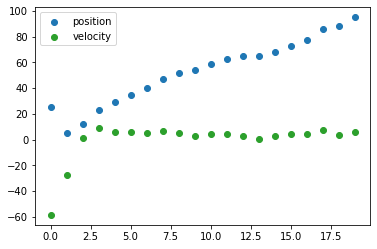

In [515]:
plt.scatter(time_array, xs[:,0], c='tab:blue', label='position')
plt.scatter(time_array, xs[:,1], c='tab:green', label='velocity')
plt.legend(loc="upper left")

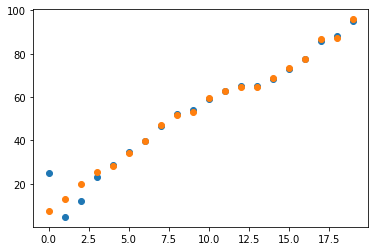

In [516]:
plt.scatter(time_array, xs[:,0], c='tab:blue', label='filter position')
plt.scatter(time_array, zs, c='tab:orange', label= "sensor position")

Velocity is technically a hidden variable, this is a multivariate Kalman filter because velocity is tracked and is being changed within our filter. Velocity is implicit within the robots movement. It helps us update our position variable. If we had a univariate case where we just tracked position, after a period of time, we couldn't model how velocity is changing therefore higher residuals in our position variable.

# Onward to plotting it as a moving Gaussian

In [533]:
gaussians = []
for i in range(len(xs)):
    gaussians.append(np.random.multivariate_normal(mean=xs[i], cov=covs[i], size=100))

In [536]:
gaussians = np.array(gaussians)

In [538]:
np.shape(gaussians)

(20, 100, 2)

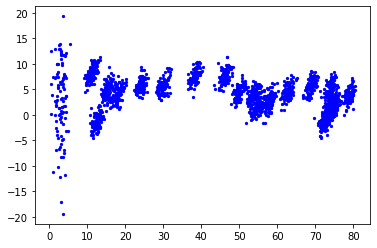

In [540]:
for i in range(20):
    plt.scatter(gaussians[i,:,0],gaussians[i,:,1], c='blue', s=5)
    #plt.savefig(str(i)+'withpost.png')
    plt.show
    

C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Connor Mignone\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.w

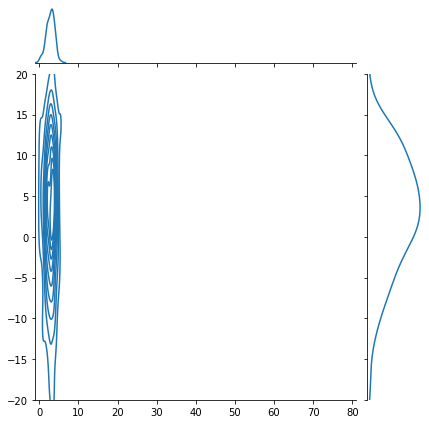

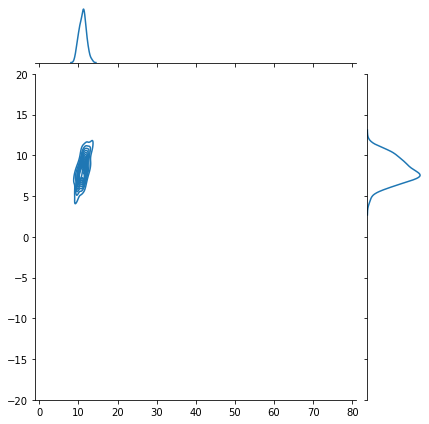

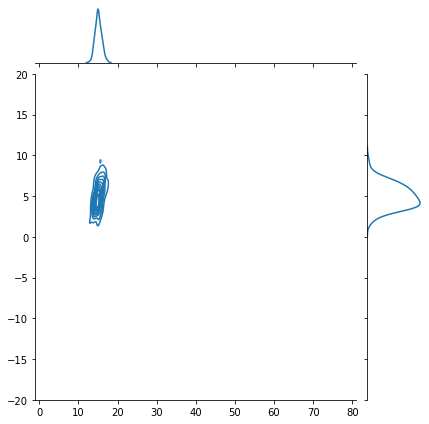

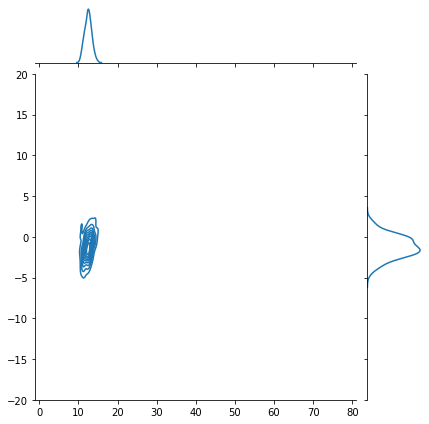

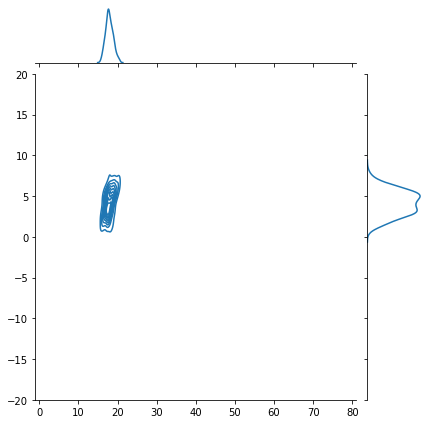

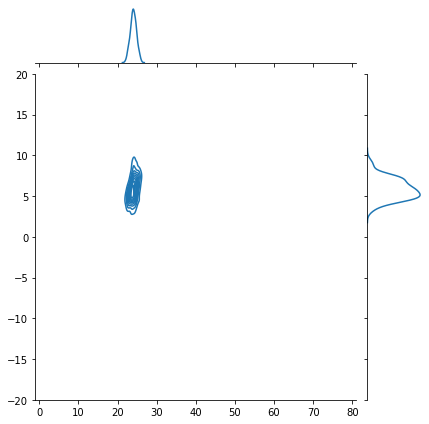

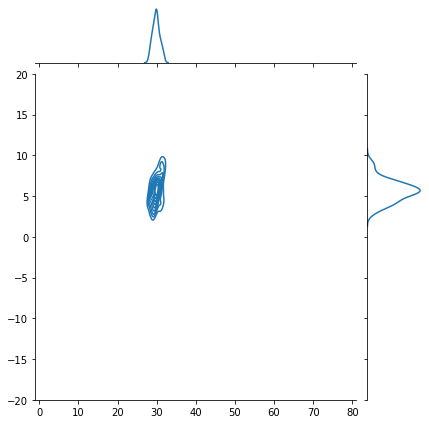

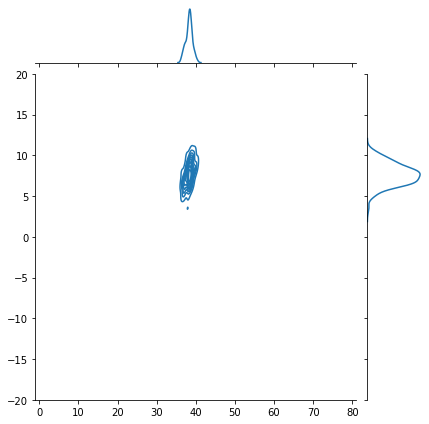

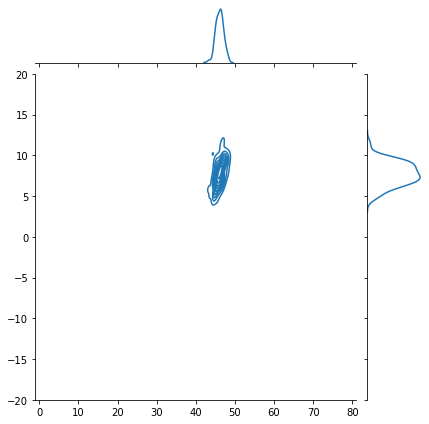

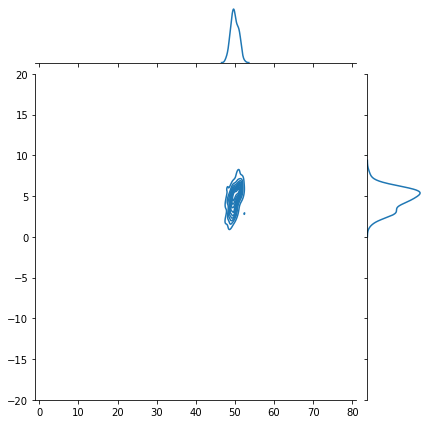

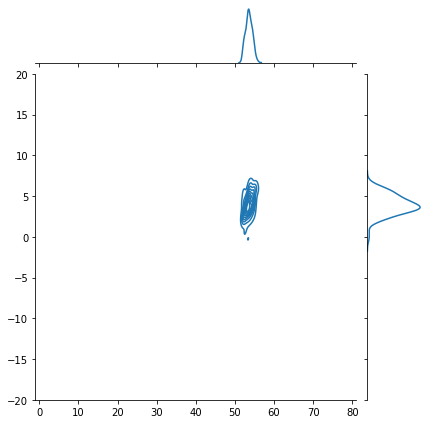

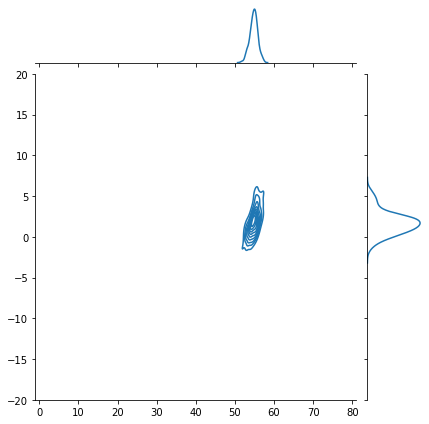

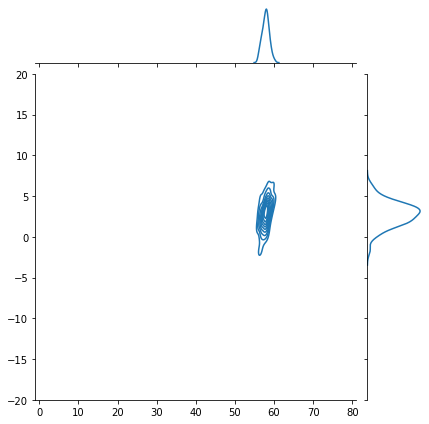

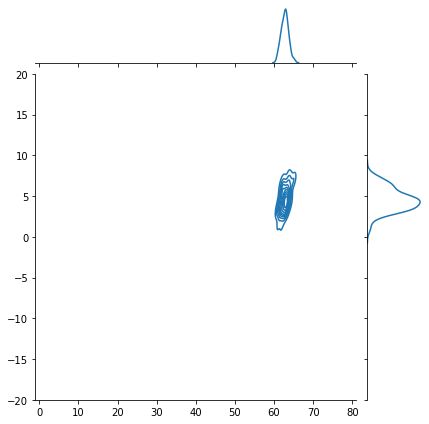

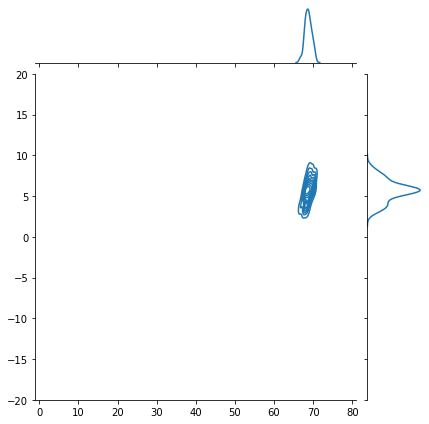

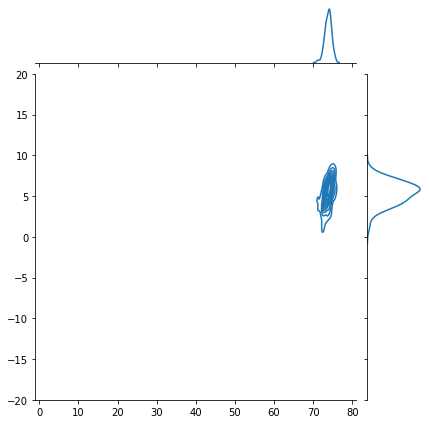

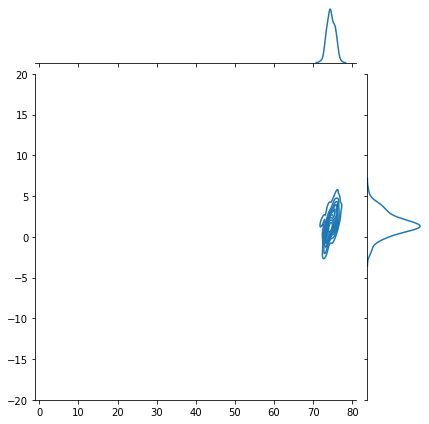

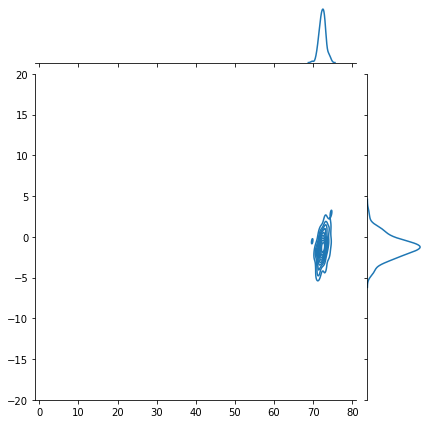

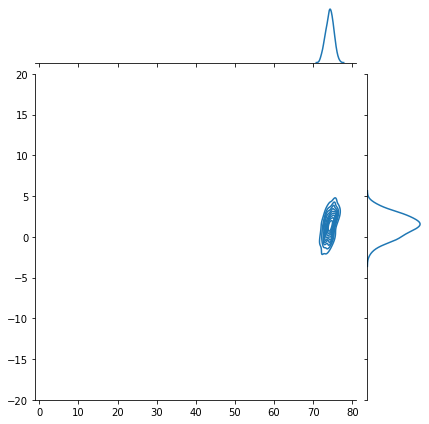

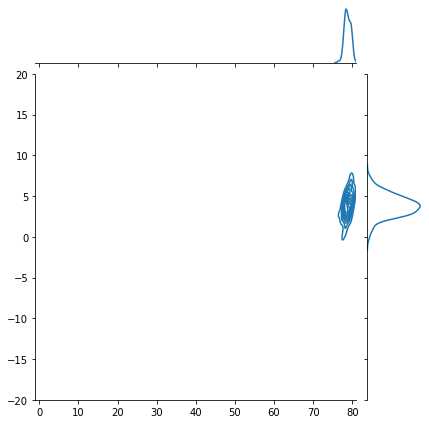

In [553]:
for i in range(20):
    g=sn.jointplot(gaussians[i,:,0],gaussians[i,:,1], kind='kde')
    g.ax_joint.set_xlim(-1,81)
    g.ax_joint.set_ylim(-20,20)
    g.ax_marg_x.set_xlim(-1,81)
    g.ax_marg_y.set_ylim(-20,20)
    g
    plt.savefig(str(i)+'kalman.png')


In [555]:

with imageio.get_writer('kalman.gif', mode='I') as writer:
    for filename in ['0kalman.png','1kalman.png', '2kalman.png', '3kalman.png', '4kalman.png','5kalman.png','6kalman.png','7kalman.png','8kalman.png','9kalman.png','10kalman.png','11kalman.png', '12kalman.png', '13kalman.png', '14kalman.png','15kalman.png','16kalman.png','17kalman.png','18kalman.png','19kalman.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

<img src="kalman.gif" width="750" align="center">

In [556]:
gif = imageio.mimread('kalman.gif')
imageio.mimsave('kalman2.gif', gif, fps=1)

<img src="kalman2.gif" width="750" align="center">

# Multivariate Gaussians and the Kalman Filter

In [487]:
# multivairate guassian distribution generation for plotting visual representation purposes
mean = np.array([1,1])
cov = np.array([[1,0],
                  [0,1]])
samples =np.random.multivariate_normal(mean, cov, 10000)


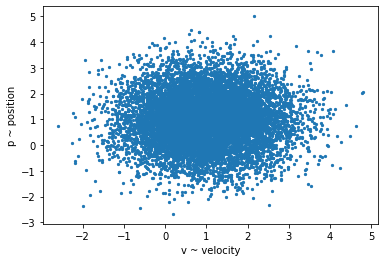

In [488]:
plt.scatter(samples[:,0],samples[:,1],s=5)
plt.ylabel('p ~ position')
plt.xlabel('v ~ velocity');

The plot above can be thought of as the joint guassian distribution of x. Here you can see that there seems to be no correlation between the points. Simply put, some negative velocities have negative positions, some have positive positions. You cannot make an easy assumption about the position based on the velocity, and vice versa, you cannot make an easy assumption about the velocity based on position.

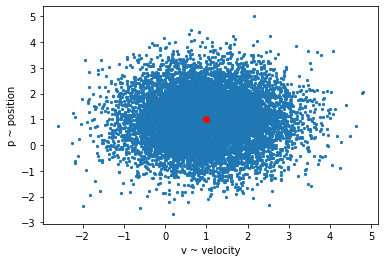

In [489]:
plt.scatter(samples[:,0],samples[:,1],s=5)
plt.scatter(mean[0],mean[1], c='red')
plt.ylabel('p ~ position')
plt.xlabel('v ~ velocity');

Above you can see a red dot, which represents a 2-dimensional mean, containing a y and a x position, or a position (in the context of the robot) and a velocity. 1,1 represents mean velocity of 1 and a postion of 1. Variance in the context of a singular variable is also easy to demonstrate.

In [490]:
vel_var_x = np.linspace(-2.9,4.9, 1000)
vel_var_y = np.ones(1000)

pos_var_y = np.linspace(-2.9,4.9, 1000)
pos_var_x = np.ones(1000)

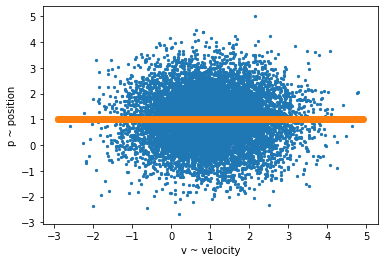

In [491]:
plt.scatter(samples[:,0],samples[:,1],s=5)
plt.scatter(mean[0],mean[1], c='red')
plt.scatter(vel_var_x, vel_var_y)
plt.ylabel('p ~ position')
plt.xlabel('v ~ velocity');

Above you can visualize the dispersion of the points long the x-axis. I previously had a misinterpretation of variance. I previously thought about it as a randomness that occured across a space. But it's more useful to think about it has a measure of a dispersion across a space.

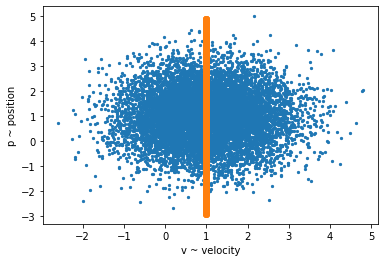

In [492]:
plt.scatter(samples[:,0],samples[:,1],s=5)
plt.scatter(mean[0],mean[1], c='red')
plt.scatter(pos_var_x, pos_var_y)
plt.ylabel('p ~ position')
plt.xlabel('v ~ velocity');

So now we have this gaussian mutlivariate distribution showing the variance of the position distribution.

We make the assumptions becasue we need to assume 